# Medicare Post-Acute Care Data Analysis

This project explores Medicare post-acute care, speficifcally home health utilization patterns across the U.S.
Using SQL and Python, I analyzed provider-level metrics such as episode counts, service days,
charges, and payments. Visualizations were created to highlight regional differences and compare
service utilization with Medicare reimbursements. Discipline metrics such as skilled nursing, physical therapy, 
occupational therapy, and speech therapy were also analzyed. 

In [ ]:
!pip install pandas matplotlib seaborn plotly

In [2]:
## Package imports
# Code to import required packages and set options for better viewing
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print ("All libraries loading!")
print (f"Pandas Version: {pd.__version__}")

All libraries loading!
Pandas Version: 2.3.1


In [43]:
##Defines file path and loads csv into a dataframe with error handling
file_path = './datasets/cms-hospital-data/Medicare_post_acute_care_utilization.csv'

try: 
    df= pd.read_csv(file_path)
    print ("Data load successfully!")
    print (f'Dataset shape: {df.shape[0]} rows x {df.shape[1]} columns')
except FileNotFoundError:
    print( "File not found. Please check the file path")
except Exception as e:
    print(f'Error loading data: {e}')

Data load successfully!
Dataset shape: 8519 rows x 78 columns


## Data Overview

The dataset contains provider-level home health metrics, including:
- Service counts and episode counts
- Charges and Medicare payments
- Provider demographics (state, city, etc.)
- Patient characteristics (age,race/sex percentages, risk scores)

Before analysis, I checked for missing values, duplicates, and column types.

In [4]:
##Checks for missing values, duplicates and provides an idea of what the variables represent
print("=== Missing Values ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data /len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count' : missing_data, 
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_summary[missing_summary['Missing Count'] > 0])

print(f"\n=== Duplicates ===")
print(f"Duplicate rows: {df.duplicated().sum()}")

print("\n=== Categorical Variables Preview ===")
for col in df.columns:
    if df[col].dtype == 'object': 
        unique_count = df[col].nunique()
        print(f"{col}: {unique_count} unique values")
        if unique_count <= 10:
            print(f" Values: {list(df[col].unique())}")
        print()

=== Missing Values ===
            Missing Count  Percentage
PRVDR_NAME              1    0.011738

=== Duplicates ===
Duplicate rows: 0

=== Categorical Variables Preview ===
YEAR_TYPE: 1 unique values
 Values: ['CY']

SMRY_CTGRY: 3 unique values
 Values: ['NATION', 'STATE', 'PROVIDER']

SRVC_CTGRY: 1 unique values
 Values: ['HH']

PRVDR_ID: 8468 unique values

PRVDR_NAME: 7046 unique values

PRVDR_CITY: 2510 unique values

STATE: 53 unique values

PRVDR_ZIP: 4166 unique values

BENE_DUAL_PCT: 100 unique values

BENE_RRL_PCT: 100 unique values

BENE_MALE_PCT: 63 unique values

BENE_FEML_PCT: 64 unique values

BENE_RACE_WHT_PCT: 101 unique values

BENE_RACE_BLACK_PCT: 101 unique values

BENE_RACE_API_PCT: 95 unique values

BENE_RACE_HSPNC_PCT: 102 unique values

BENE_RACE_NATIND_PCT: 41 unique values

BENE_RACE_UNK_PCT: 53 unique values

BENE_RACE_OTHR_PCT: 15 unique values

BENE_CC_BH_ADHD_OTHCD_V1_PCT: 26 unique values

BENE_CC_BH_ALCOHOL_DRUG_V1_PCT: 57 unique values

BENE_CC_BH_ALZ

In [45]:
#Creates SQLite database with verification of table name via print function
db_path = '../clinical-data-projects/medicare_analysis.db'
conn = sqlite3.connect(db_path)

table_name = 'medicare_post_acute_care'
df.to_sql(table_name, conn, if_exists='replace', index=False)

print(f" Data loaded into Sqlite DB: {db_path}")
print(f" Table name: {table_name}")

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

 Data loaded into Sqlite DB: ../clinical-data-projects/medicare_analysis.db
 Table name: medicare_post_acute_care


In [46]:
##Function to run SQL queries and return results as dataframe
def run_sql_query(query, description=""):
    """Execute SQL query and return results as pandas Dataframe"""
    try: 
        result = pd.read_sql_query(query, conn)
        if description:
            print(f"=== {description} ===")
        return result
    except Exception as e: 
        print(f" Error executing query: {e}")
        return None

##SQL Select Statement
##Query 1 Basic SELECT statement to view first 55 rows
query1 = f"""
SELECT *
FROM {table_name}
LIMIT 55;
"""
result1 = run_sql_query(query1, "First 55 Records")
display(result1)

=== First 55 Records ===


,YEAR,YEAR_TYPE,SMRY_CTGRY,SRVC_CTGRY,PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,PRVDR_ZIP,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,TOT_MDCR_STDZD_PYMT_AMT,TOT_OUTLIER_PYMT_AMT,BENE_DUAL_PCT,BENE_RRL_PCT,BENE_AVG_AGE,BENE_MALE_PCT,BENE_FEML_PCT,BENE_RACE_WHT_PCT,BENE_RACE_BLACK_PCT,BENE_RACE_API_PCT,BENE_RACE_HSPNC_PCT,BENE_RACE_NATIND_PCT,BENE_RACE_UNK_PCT,BENE_RACE_OTHR_PCT,BENE_AVG_RISK_SCRE,BENE_CC_BH_ADHD_OTHCD_V1_PCT,BENE_CC_BH_ALCOHOL_DRUG_V1_PCT,BENE_CC_BH_ALZ_NONALZDEM_V2_PCT,BENE_CC_BH_ANXIETY_V1_PCT,BENE_CC_BH_BIPOLAR_V1_PCT,BENE_CC_BH_DEPRESS_V1_PCT,BENE_CC_BH_MOOD_V2_PCT,BENE_CC_BH_PD_V1_PCT,BENE_CC_BH_PTSD_V1_PCT,BENE_CC_BH_SCHIZO_OTHPSY_V1_PCT,BENE_CC_BH_TOBACCO_V1_PCT,BENE_CC_PH_AFIB_V2_PCT,BENE_CC_PH_ARTHRITIS_V2_PCT,BENE_CC_PH_ASTHMA_V2_PCT,BENE_CC_PH_CANCER6_V2_PCT,BENE_CC_PH_CKD_V2_PCT,BENE_CC_PH_COPD_V2_PCT,BENE_CC_PH_DIABETES_V2_PCT,BENE_CC_PH_HF_NONIHD_V2_PCT,BENE_CC_PH_HYPERLIPIDEMIA_V2_PCT,BENE_CC_PH_HYPERTENSION_V2_PCT,BENE_CC_PH_ISCHEMICHEART_V2_PCT,BENE_CC_PH_OSTEOPOROSIS_V2_PCT,BENE_CC_PH_PARKINSON_V2_PCT,BENE_CC_PH_STROKE_TIA_V2_PCT,PRMRY_DX_INFCTN_PCT,PRMRY_DX_NEOBLD_PCT,PRMRY_DX_ENDONUTRMET_PCT,PRMRY_DX_MNTBEHNEUDIS_PCT,PRMRY_DX_NERVSYSTM_PCT,PRMRY_DX_ENTSYS_PCT,PRMRY_DX_CIRCSYSTM_PCT,PRMRY_DX_RSPSYSTM_PCT,PRMRY_DX_DIGSYSTM_PCT,PRMRY_DX_SKNMUSSYSTM_PCT,PRMRY_DX_GUSYSTM_PCT,PRMRY_DX_PRGPERICONG_PCT,PRMRY_DX_SXILLDEF_PCT,PRMRY_DX_INJPOIS_PCT,PRMRY_DX_HLTHSRV_PCT,NRSNG_VISITS_CNT,MSW_VISITS_CNT,AIDE_VISITS_CNT,TOT_NRSNG_MNTS,TOT_PT_MNTS,TOT_OT_MNTS,TOT_SLP_MNTS,TOT_HH_LUPA_EPSDS_CNT
0,2023,CY,NATION,HH,NATIONAL TOTAL,NATIONAL TOTAL,NATIONAL TOTAL,NATIONAL TOTAL,NATIONAL TOTAL,2703071,8248545,58609540,20033506813,15717592199,15717592199,15883712576,352114221,24,7,78,40,60,79,9,3,6,0,2,1,2.11,1,11,26,39,7,40,44,2,2,5,14,34,69,14,19,42,30,44,39,83,91,45,22,6,18,1,3,9,2,8,0,23,6,2,15,3,0,0,11,15,32192577,396010,3428186,1395149580,1062704715,289006110,53445045,567015
1,2023,CY,STATE,HH,STATE TOTAL,STATE TOTAL,STATE TOTAL,AK,STATE TOTAL,3128,7847,55276,20655298,17724324,17724324,15666163,394331,37,22,77,39,61,79,3,4,2,10,1,1,2.05,1,16,31,34,8,37,41,3,4,4,20,35,64,15,17,38,32,41,37,70,87,37,22,6,19,1,3,5,2,10,0,15,5,2,20,3,*,0,15,19,25300,657,2822,1208040,1277805,369555,83850,707
2,2023,CY,STATE,HH,STATE TOTAL,STATE TOTAL,STATE TOTAL,AL,STATE TOTAL,47660,159558,1023170,535668906,234954332,234954332,302210742,2330440,18,13,78,39,61,84,14,0,1,0,1,0,1.98,1,10,27,40,6,39,43,2,2,4,17,35,69,13,18,44,34,46,40,83,94,47,20,5,19,1,4,9,2,7,0,26,8,2,12,4,0,0,10,14,519080,6029,36591,21945285,18741555,5731515,1518060,11376
3,2023,CY,STATE,HH,STATE TOTAL,STATE TOTAL,STATE TOTAL,AR,STATE TOTAL,29245,90055,613231,421499452,139987887,139987887,168361413,1382627,20,26,78,40,60,90,8,0,1,0,1,0,2.08,1,11,24,40,7,42,45,2,2,3,18,38,66,12,19,41,35,42,43,78,93,50,21,5,20,1,4,8,1,8,0,26,8,2,13,4,0,0,11,13,326271,3150,37318,13494450,10994505,2504820,668760,6734
4,2023,CY,STATE,HH,STATE TOTAL,STATE TOTAL,STATE TOTAL,AZ,STATE TOTAL,44207,114295,761009,260717648,210539881,210539881,221552610,2422068,12,2,79,41,59,85,2,1,7,2,1,1,2.10,1,13,26,37,7,40,43,2,2,3,12,36,67,15,21,45,30,40,35,82,90,44,25,6,20,2,3,6,2,9,0,19,6,2,14,4,0,0,16,17,362099,7420,33441,16728270,16065990,4373040,780195,9669
5,2023,CY,STATE,HH,STATE TOTAL,STATE TOTAL,STATE TOTAL,CA,STATE TOTAL,346515,1251352,9025597,2194747503,3006762727,3006762727,2336735985,106432778,49,1,78,41,59,60,6,12,16,0,4,2,2.12,1,12,27,33,6,39,43,1,2,7,12,29,68,16,17,39,27,48,38,83,91,44,26,6,17,1,3,15,1,8,0,24,5,1,21,3,0,0,7,10,6216609,69634,542552,296493285,126528060,23541285,3598050,60207
6,2023,CY,STATE,HH,STATE TOTAL,STATE TOTAL,STATE TOTAL,CO,STATE TOTAL,26319,66278,467305,136623427,125714029,125714029,128842302,2103567,18,6,79,39,61,85,3,2,8,0,2,1,2.01,1,13,27,35,7,42,45,2,3,3,12,31,68,14,19,43,29,33,34,73,84,36,26,6,16,2,3,6,2,11,0,16,6,2,15,3,0,0,15,18,169202,2475,15842,6927420,11571135,3655320,643155,5425
7,2023,CY,STATE,HH,STATE TOTAL,STAT

### Data Cleaning: Removing "TOTAL" Rows

Some rows contained provider IDs with the label "TOTAL," which are aggregate rows. For the purpose of this project, the "TOTAL" rows were removed.  
These could bias the state-level and provider-level analysis and skew data in various directions.  

The following SQL query demonstrates a `DELETE` operation in SQLite to remove those rows.  

In [47]:
def run_sql_command(query, description=""):
    """Execute SQL command (DELETE, UPDATE, INSERT) that does not return rows."""
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        conn.commit()
        if description:
            print(f"=== {description} ===")
        print(f"Command executed successfully. Rows affected: {cursor.rowcount}")
    except Exception as e:
        print(f"Error executing command: {e}")

In [48]:
##SQL Data Manipulation Example
##Query to delete "total" rows to prevent skewed analysis further on
query2 = f"""
DELETE FROM {table_name}
WHERE [PRVDR_ID] LIKE '%TOTAL%';
"""
run_sql_command(query2, "Removed TOTAL rows")

=== Removed TOTAL rows ===
Command executed successfully. Rows affected: 53


In [49]:
## Query to display first 5 rows to verify "total" rows were deleted given how the first 53 rows were "total" rows
verify_query = f"""
SELECT [PRVDR_NAME]
FROM {table_name}
LIMIT 5;
"""
verify_data = run_sql_query(verify_query, "First Five Providers")
display(verify_data)

=== First Five Providers ===


,PRVDR_NAME
0,Providence Home Health Alaska
1,Fairbanks Memorial Hospital Hha
2,Ancora Home Health & Hospice
3,Petersburg Medical Center Home
4,South Peninsula Hospital Hha


In [36]:
##SQL Total Records
##Query to output total record count; given the original count of 8519, we can also subtract 53 to get the new count of 8466. 
print("Original Dataset: 8519 rows")

query3 = f"""
SELECT COUNT(*) as total_records
FROM {table_name};
"""

total_count = run_sql_query(query3, "New Dataset")
display(total_count)

Original Dataset: 8519 rows
=== New Dataset ===


,total_records
0,8466


## Average Service Days by State

This query calculates the average number of service days per episode across all states.
It highlights differences in utilization by region.

=== Average Service Days by State ===


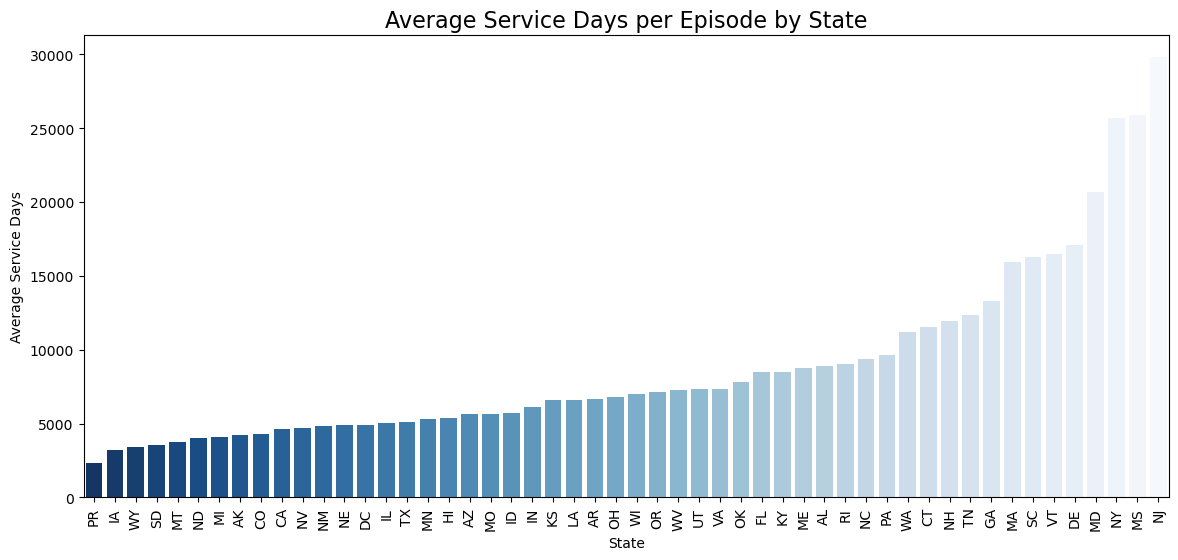

In [10]:
query = f"""
SELECT
    [STATE],
    AVG([TOT_SRVC_DAYS]) as avg_service_days
FROM {table_name}
GROUP BY [STATE]
ORDER BY avg_service_days ASC
"""
service_days = run_sql_query(query, "Average Service Days by State")

plt.figure(figsize=(14,6))
sns.barplot(x="STATE", y="avg_service_days", data=service_days, palette="Blues_r")
plt.title("Average Service Days per Episode by State", fontsize=16)
plt.xticks(rotation=90)
plt.ylabel("Average Service Days")
plt.xlabel("State")
plt.show()

**Insight:**  
There is notable variation between states. Some states average significantly higher service
days per episode, suggesting differences in patient needs or provider practice patterns. 
Additionally, further statiscial analysis should be performed to examine other factors that
impact this visualizaton such as number of providers per state. 

## Relationship Between Episode Count and Service Days

Here I compared total episodes (`TOT_EPSD_STAY_CNT`) with total service days (`TOT_SRVC_DAYS`).
This helps visualize whether states with more episodes also tend to provide longer or shorter care. 
We should expect a positive correlation between episode counts and total service days as traditionally, 
episodes are 60-days in length. However, service days can be impacted by repeated hospitalizations and/or 
agency discharges.

=== Episode Count vs Service Days ===


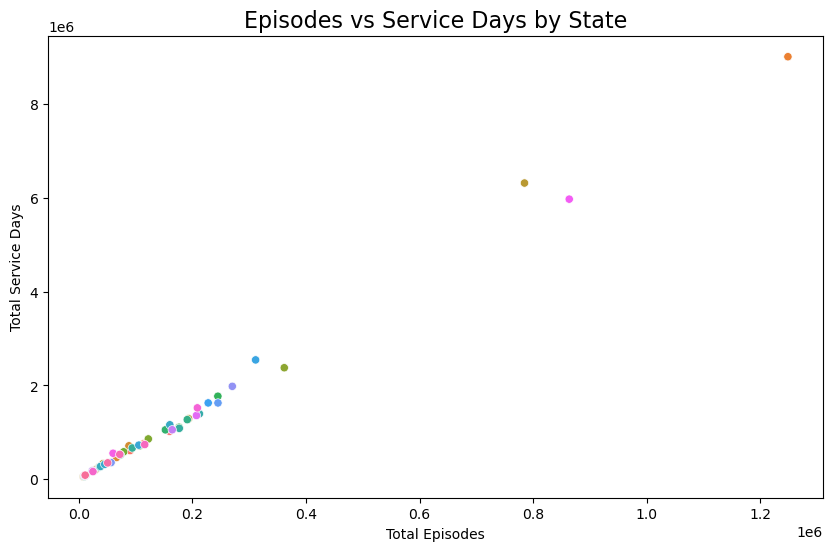

In [11]:
query = f"""
SELECT
    [STATE],
    SUM([TOT_EPSD_STAY_CNT]) as total_episodes,
    SUM([TOT_SRVC_DAYS]) as total_service_days
FROM {table_name}
GROUP BY [STATE]
"""
episode_days = run_sql_query(query, "Episode Count vs Service Days")

plt.figure(figsize=(10,6))
sns.scatterplot(x="total_episodes", y="total_service_days", data=episode_days, hue="STATE", legend=False)
plt.title("Episodes vs Service Days by State", fontsize=16)
plt.xlabel("Total Episodes")
plt.ylabel("Total Service Days")
plt.show()

**Insight:**  
The scatter plot shows a strong positive relationship: states with more episodes also tend to
have higher total service days. This is expected, but variation across states suggests some deliver
more care per episode than others.

## Distribution of Average Patient Age

This chart shows the distribution of average patient age across providers.

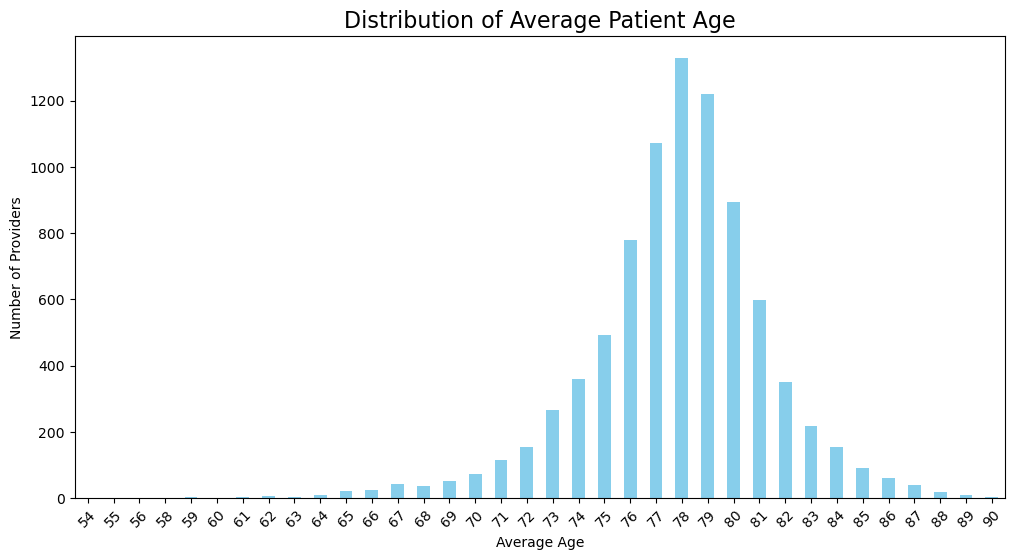

In [12]:
plt.figure(figsize=(12,6))
age_distribution = df['BENE_AVG_AGE'].value_counts().sort_index()
age_distribution.plot(kind='bar', color="skyblue")
plt.title("Distribution of Average Patient Age", fontsize=16)
plt.xlabel("Average Age")
plt.ylabel("Number of Providers")
plt.xticks(rotation=45)
plt.show()

**Insight:**  
Most providers cluster around the mid-to-late 70s. This aligns with the Medicare population,
though some providers serve slightly younger or older patients.

## Therapy and Nursing Minutes by State

Here I calculated the average total minutes of PT, OT, SLP, and Nursing care across states.
This highlights how care is distributed among disciplines. Historically, we would expect to see larger number
of patients receiving skilled nursing care. 

=== Total Minutes by Discipline and State ===


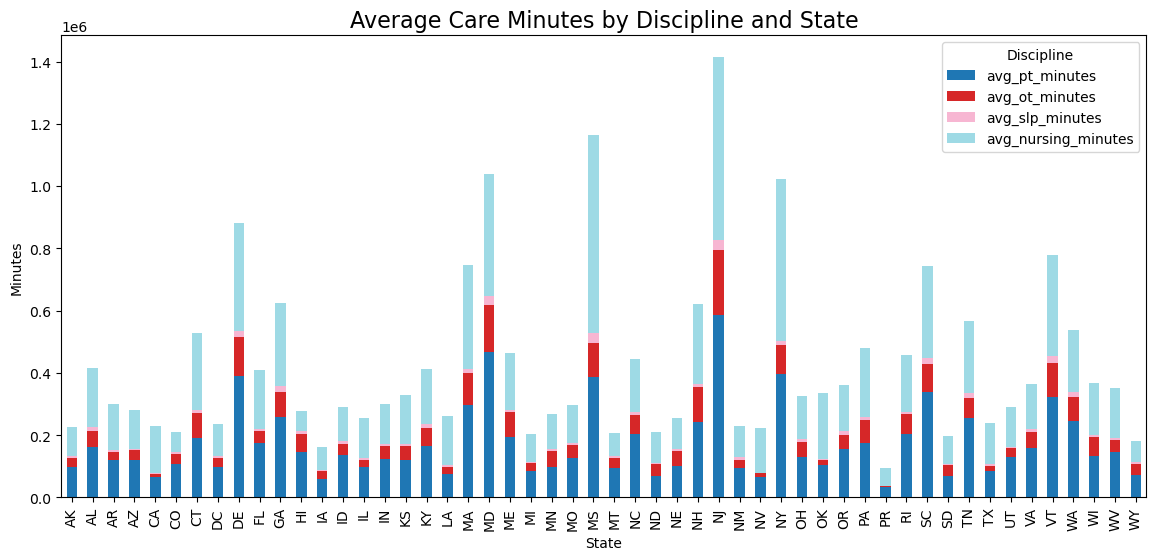

In [50]:
# Step 6: Total Minutes by Discipline
query = f"""
SELECT
    [STATE],
    AVG([TOT_PT_MNTS]) as avg_pt_minutes,
    AVG([TOT_OT_MNTS]) as avg_ot_minutes,
    AVG([TOT_SLP_MNTS]) as avg_slp_minutes,
    AVG([TOT_NRSNG_MNTS]) as avg_nursing_minutes
FROM {table_name}
GROUP BY [STATE]
"""
minutes = run_sql_query(query, "Total Minutes by Discipline and State")

# Safety check
if minutes is not None and not minutes.empty:
    minutes.set_index("STATE", inplace=True)
    minutes.plot(kind="bar", stacked=True, figsize=(14,6), colormap="tab20")
    plt.title("Average Care Minutes by Discipline and State", fontsize=16)
    plt.ylabel("Minutes")
    plt.xlabel("State")
    plt.legend(title="Discipline")
    plt.show()
else:
    print("No data returned from the query.")

**Insight:**  
Nursing minutes dominate overall service time, followed by PT. OT and SlP.
This distribution is consistent with home health being nursing-led, with therapy playing a
supporting role for beneficiaries.

## Comparing Service Minutes with Charges and Medicare Payments

To understand cost efficiency, I compared state-level totals for PT/OT/SLP/Nursing minutes
with provider charges and Medicare payments.

=== Minutes vs Charges/Payments by State ===


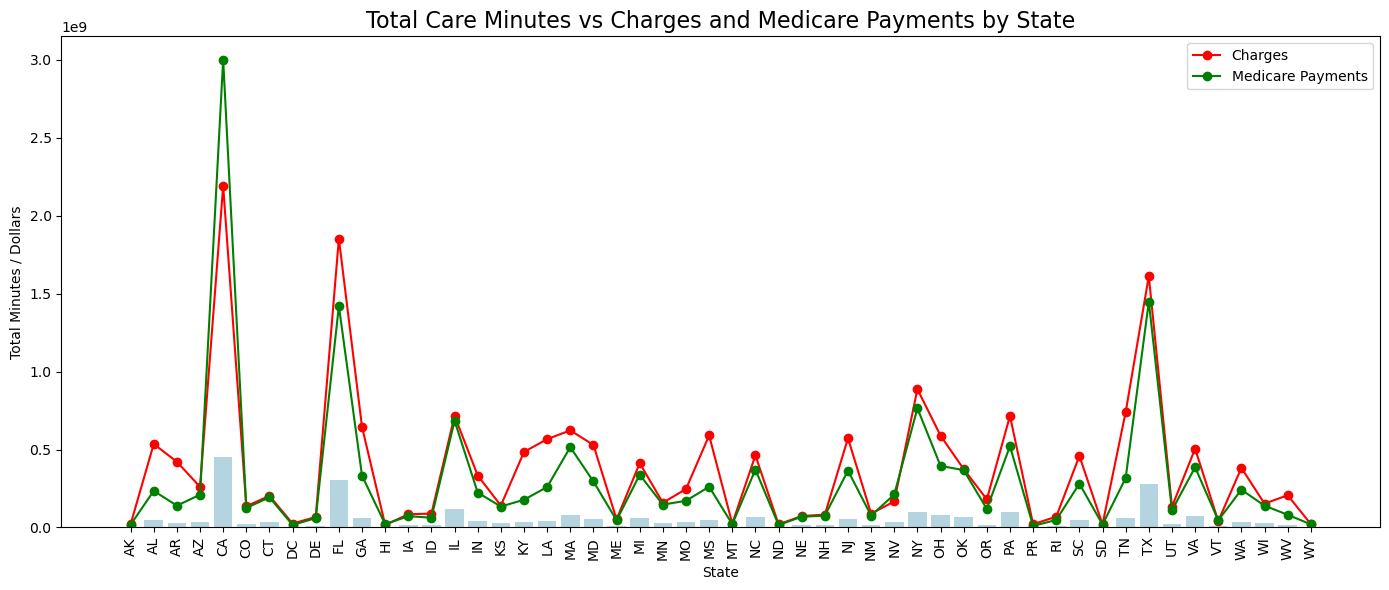

In [51]:
# Step 7: Comparing Minutes to Charges and Medicare Payments
query = f"""
SELECT
    [STATE],
    SUM([TOT_PT_MNTS] + [TOT_OT_MNTS] + [TOT_SLP_MNTS] + [TOT_NRSNG_MNTS]) as total_minutes,
    SUM([TOT_CHRG_AMT]) as total_charges,
    SUM([TOT_MDCR_PYMT_AMT]) as total_medicare_payments
FROM {table_name}
GROUP BY [STATE]
"""
minutes_charges = run_sql_query(query, "Minutes vs Charges/Payments by State")

# Safety check
if minutes_charges is not None and not minutes_charges.empty:
    plt.figure(figsize=(14,6))
    
    # Bar for total minutes
    sns.barplot(x="STATE", y="total_minutes", data=minutes_charges, color="lightblue")
    
    # Line plots for charges and Medicare payments
    plt.plot(minutes_charges["STATE"], minutes_charges["total_charges"], color="red", marker='o', label="Charges")
    plt.plot(minutes_charges["STATE"], minutes_charges["total_medicare_payments"], color="green", marker='o', label="Medicare Payments")
    
    plt.title("Total Care Minutes vs Charges and Medicare Payments by State", fontsize=16)
    plt.xlabel("State")
    plt.ylabel("Total Minutes / Dollars")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data returned from the query.")

**Insight:**  
Charges are consistently higher than Medicare payments across states, indicating a gap between
provider billing and reimbursement. States with higher care minutes tend to show higher charges,
but the correlation with Medicare payments is weaker. As home health reimbursements continue to decrease, 
agencies across the states may struggle with daily operational costs and providing medically necessary care. 

# Conclusion

This analysis demonstrated key patterns in Medicare home health utilization:
- Service days and episode counts vary widely across states but are often positively correlated.
- Nursing dominates total care minutes, while PT and OT play smaller but still significant roles.
- Charges consistently exceed standardized Medicare payments, reflecting common reimbursement
challenges in home health, espeically as reimbursement ra
- Patient demographics (such as age) align with expectations for the Medicare population.

Overall, this project highlights how SQL and Python can be combined to explore healthcare data,
derive insights, and visualize utilization trends.